In [ ]:
# To use in Google Colab or Kaggle Notebooks
!pip install datasets==2.14.5
!pip install torch==2.0.0
!pip install transformers==4.34.0
!pip install tqdm==4.66.1
!pip install tokenizers==0.14.1
!pip install pandas==2.0.3
!pip install scikit-learn==1.3.1
!pip install matplotlib==3.8.0
!pip install --upgrade numpy==1.22.4

In [4]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from enum import Enum
import matplotlib.pyplot as plt


# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [6]:
def filter_and_preprocess(data):
    """
    Filters a list of dictionaries by only including entries with services
    either "restaurant" or "hotel" and having only one service.

    Parameters:
    - data: list of dictionaries containing a "services" key, which is a list of services.

    Returns:
    - List of filtered dictionaries.
    """
    return [entry for entry in data if set(entry["services"]).issubset({"restaurant", "hotel"}) and len(entry["services"]) == 1]


train_data_filtered = filter_and_preprocess(train_data)
val_data_filtered = filter_and_preprocess(val_data)
test_data_filtered = filter_and_preprocess(test_data)

In [12]:
def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Loop through each turn in the dialogue
        for i in range(num_turns):

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]
            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']

            # Append as a dictionary to the data list
            data.append({'Utterance': utterance, 'DialogueAct': dialogue_act})

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['Utterance']
    Y = df['DialogueAct']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data_filtered)
X_val, Y_val = toDataFrame(val_data_filtered)
X_test, Y_test = toDataFrame(test_data_filtered)

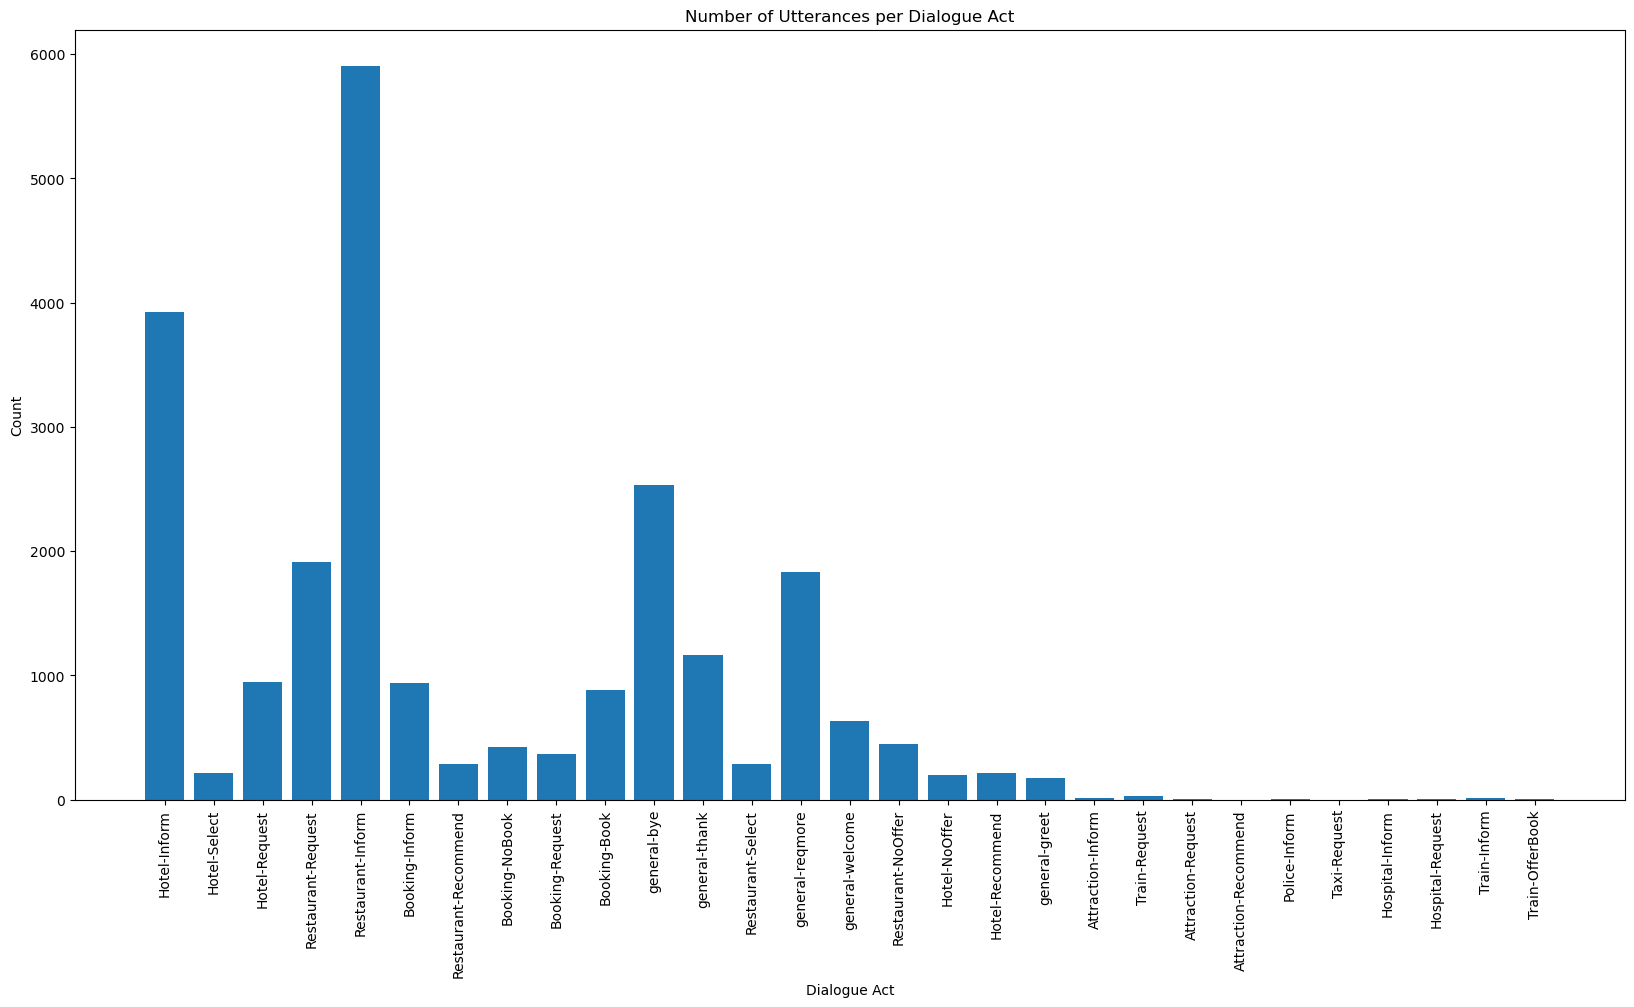

[('Attraction-Recommend', 1), ('Taxi-Request', 1), ('Train-OfferBook', 3), ('Attraction-Request', 5), ('Hospital-Request', 5), ('Police-Inform', 7), ('Hospital-Inform', 7), ('Train-Inform', 10), ('Attraction-Inform', 12), ('Train-Request', 26)]


In [24]:
# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance. 
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_train:
        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:
            
            # If the dialogue act is already in the dictionary, increment its count by 1
            if dialogue_act in counts:
                counts[dialogue_act] += 1
            
            # If the dialogue act is not already in the dictionary, set its count to 1
            else:
                counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

# Bottom 10 dialogue acts
sorted_counts = sorted(counts.items(), key=lambda item: item[1])
print(sorted_counts[:10])
